In [1]:
import os
os.environ['CMDSTAN'] = '/Users/michelafrigeri/.cmdstan/cmdstan-2.28.2'
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
# Dataset import

df = pd.read_csv("Py_Dataset.csv")
df.head()

,Unnamed: 0,Date,Y_bc,Rural,Time,NS,quota,Provincia,Zonizzazione,Tipo
0,1,2018-01-01,3.603935,1,0,BADIA,202.0,PR,Pianura Ovest,Fondo
1,2,2018-01-02,2.696869,1,1,BADIA,202.0,PR,Pianura Ovest,Fondo
2,3,2018-01-03,2.642399,1,2,BADIA,202.0,PR,Pianura Ovest,Fondo
3,4,2018-01-04,2.799438,1,3,BADIA,202.0,PR,Pianura Ovest,Fondo
4,5,2018-01-05,3.480090,1,4,BADIA,202.0,PR,Pianura Ovest,Fondo


2.214512289118072

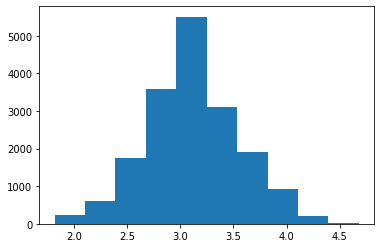

In [3]:
plt.hist(df.Y_bc)
np.std(df.Y_bc)*5 # a = 2, b = 3 per invgamma

In [4]:
# dummies

dummies = pd.get_dummies(df.Tipo)
dummies.head()

,Fondo,Industriale,Traffico
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


# MODEL INPUT

- N = length Y = number of total samples 
- k = number of Fourier basis (1/4/12)
- p = 3 = number of regressors {quota + tipo(dummyx2)}


- y {N vector} : PM10 time series
- x {Nxp matrix} : covariates matrix
- t {N vector} : time istant
- r {N vector binary} : 1 if rural, 0 otherwise
- omega = 1/365 : annual frequency


# MODEL PARAMETERS

- a {k/2 vector} : sin coefficients
- b {k/2 vector} : cos coefficients
- c {real} : constant term for f(t)


- a_r {k/2 vector} : sin coefficients - rural 
- b_r {k/2 vector} : cos coefficients - rural
- c_r {real} : constant term for fr(t) - rural


- beta {p vector} : covariates coefficients
- sigma {real > 0} : y variance


In [17]:
normal_reg = """
data {
    int<lower=0> N; 
    int<lower=0> k;
    int<lower=0> p;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    real omega;
}

transformed data {
    int K;
    K = k%/%2;
}

parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[K] a;
    vector[K] b;
    real c;
    
    vector[K] a_r;
    vector[K] b_r;
    real c_r;
}


transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma_sq);
    
    vector[N] ft;
    ft = to_vector(rep_array(c, N));
    for (j in 1:K){
     ft += a[j]*sin(K*omega*t) + b[j]*cos(K*omega*t);
    }
    
    vector[N] ft_r;
    ft_r = to_vector(rep_array(c_r, N));
    for (j in 1:K){
     ft_r += a_r[j]*sin(K*omega*t) + b_r[j]*cos(K*omega*t);
    }
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) 
         + X*beta;
}

model {  

    sigma_sq ~ inv_gamma(2, 3);
    
    beta ~ normal(0, 10);
    
    a ~ normal(0, 10);
    b ~ normal(0, 10);
    c ~ normal(0, 10);
    
    a_r ~ normal(0, 10);
    b_r ~ normal(0, 10);
    c_r ~ normal(0, 10);
    
    
    Y ~ normal(mu, sigma);  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sigma);
  }
}
"""

stan_file = "./normal_reg.stan"

with open(stan_file, "w") as f:
    print(normal_reg, file=f)

normal_reg = CmdStanModel(stan_file=stan_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_reg
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/michelafrigeri/JupyterProjects/PROGETTO/normal_reg


In [18]:
y = np.array(df.Y_bc)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
omega = 1/365

N = len(y)
p = 3   # Quota + Tipo(2 dummies)
k = 2   # 4 basi di fourier + const

In [19]:
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "k": k,   # Fbasis number
    "p": p,   # 3
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,   
    "omega": omega
}

fit = normal_reg.sample(data=reg_data, show_progress=True)


Chain 2 -   done: 100%|█████████████████████| 3000/3000 [44:14<00:00,  1.13it/s]


In [20]:
normal_az = az.from_cmdstanpy(fit)

In [37]:
type(fit)

cmdstanpy.stanfit.CmdStanMCMC

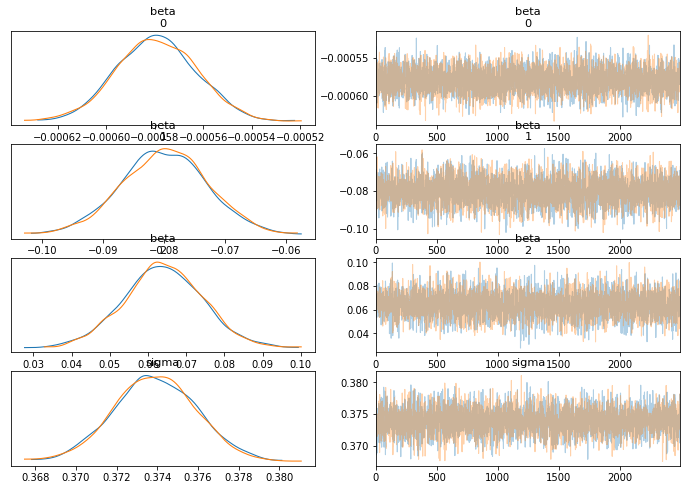

In [21]:
# parameters: beta and sigma
az.plot_trace(normal_az, var_names=["beta", "sigma"], compact=False)
plt.show()

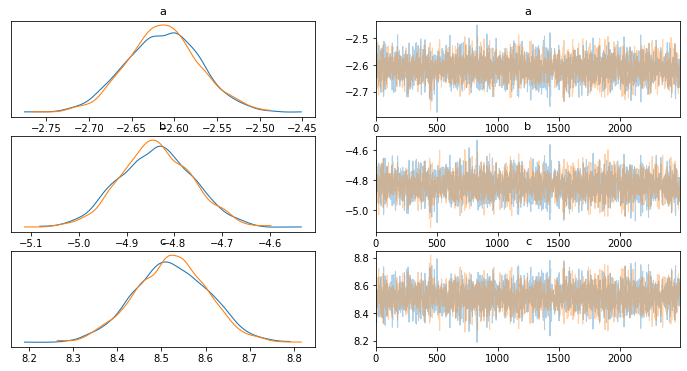

In [22]:
# parameters NON-rural f(t)
az.plot_trace(normal_az, var_names=["a", "b", "c"], compact=False)
plt.show()

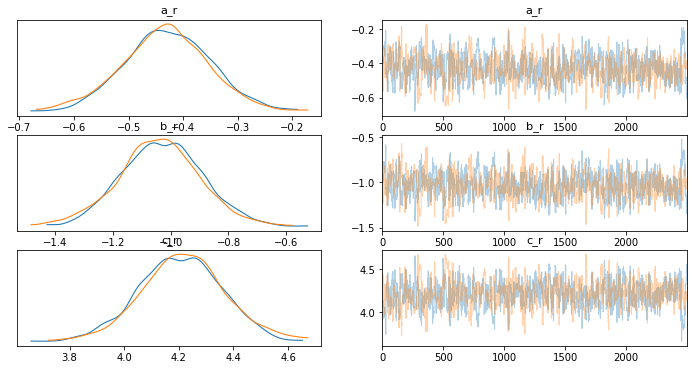

In [23]:
# parameters rural f(t)
az.plot_trace(normal_az, var_names=["a_r", "b_r", "c_r"], compact=False)
plt.show()

In [24]:
# iterazioni divergenti? Nessuna
np.sum(normal_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

In [25]:
# GOF analysis
print("WAIC: ", az.waic(normal_az, var_name="log_lik"))

WAIC:  Computed from 5000 by 17836 log-likelihood matrix

          Estimate       SE
elpd_waic -7745.72   106.94
p_waic       11.58        -


In [26]:
print("LOO: ", az.loo(normal_az, var_name="log_lik"))

LOO:  Computed from 5000 by 17836 log-likelihood matrix

         Estimate       SE
elpd_loo -7745.72   106.94
p_loo       11.58        -


In [ ]:
# per scegliere modello migliore
# az.compare({"model_1": normal_az, "model_2": modello_new})